In [2]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras import backend as K

In [3]:
def iou(y_true, y_pred):
  def f(y_true, y_pred):
    intersection = (y_true * y_pred).sum()
    union = y_true.sum() + y_pred.sum() - intersection
    x = (intersection + 1e-15) / (union + 1e-15)
    x = x.astype(np.float32)
    return x
  return tf.numpy_function(f, [y_true, y_pred], tf.float32)

In [4]:
def dice_coeff(y_true, y_pred, smoothness = 100):
  y_true_f = K.flatten(y_true)
  y_pred_f = K.flatten(y_pred)
  intersection = K.sum(y_true_f * y_pred_f)
  return (2. * intersection + smoothness) / (K.sum(y_true_f) + K.sum(y_pred_f) + smoothness)

In [5]:
def precision(y_true, y_pred):    
  true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
  precision = true_positives / (predicted_positives + K.epsilon())
  return precision

In [6]:
def recall(y_true, y_pred):    
  true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
  recall = true_positives / (possible_positives + K.epsilon())
  return recall

In [7]:
def accuracy(y_true, y_pred):    
  return K.mean(K.equal(y_true, K.round(y_pred)))

In [8]:
def double_conv(x, num_filters):
  x = Conv2D(num_filters, (3, 3), padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(num_filters, (3, 3), padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  
  return x

In [9]:
def gating_signal(input, output_size):
  x = Conv2D(output_size, (1, 1), padding='same')(input)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  return x

In [10]:
def expend_as(tensor, rep):
  return Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3),
                      arguments={'repnum': rep})(tensor)

In [11]:
def attention_block(x, gating, inter_shape):
  shape_x = K.int_shape(x)
  shape_g = K.int_shape(gating)

  theta_x = Conv2D(inter_shape, (2, 2), strides=(2, 2), padding='same')(x)  # 16
  shape_theta_x = K.int_shape(theta_x)

  phi_g = Conv2D(inter_shape, (1, 1), padding='same')(gating)
  upsample_g = Conv2DTranspose(inter_shape, (3, 3),
                                strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]),
                                padding='same')(phi_g)

  concat_xg = add([upsample_g, theta_x])
  act_xg = Activation('relu')(concat_xg)
  psi = Conv2D(1, (1, 1), padding='same')(act_xg)
  sigmoid_xg = Activation('sigmoid')(psi)
  shape_sigmoid = K.int_shape(sigmoid_xg)
  upsample_psi = UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)  # 32

  upsample_psi = expend_as(upsample_psi, shape_x[3])

  y = multiply([upsample_psi, x])

  result = Conv2D(shape_x[3], (1, 1), padding='same')(y)
  result_bn = BatchNormalization()(result)
  return result_bn

In [17]:
def SE_block(x, out_dim, ratio):    
  x_s = GlobalAveragePooling2D(data_format=None)(x)
  x_s = BatchNormalization()(x_s)
  x_e = Dense(units=out_dim//ratio)(x_s)
  x_e = Activation('relu')(x_e)
  x_e = BatchNormalization()(x_e)
  x_e = Dense(units=out_dim)(x_e)
  x_e = Activation('sigmoid')(x_e)
  x_e = Reshape((1, 1, out_dim))(x_e)
  result = multiply([x, x_e])
  return result

In [13]:
def UNET_Spatial_Attention():
    
  input_shape = 256
  num_filters = 64
  input_layer = Input(shape=(input_shape, input_shape, 3))  
  
  #Downsampling
  conv_128 = double_conv(input_layer, num_filters)
  pool_64 = MaxPooling2D()(conv_128)

  conv_64 = double_conv(pool_64, num_filters*2)
  pool_32 = MaxPooling2D()(conv_64)

  conv_32 = double_conv(pool_32, num_filters*4)
  pool_16 = MaxPooling2D()(conv_32)

  conv_16 = double_conv(pool_16, num_filters*8)
  pool_8 = MaxPooling2D()(conv_16)

  conv_8 = double_conv(pool_8, num_filters*16)

  #Upsampling
  gating_16 = gating_signal(conv_8, num_filters*8)
  att_16 = attention_block(conv_16, gating_16, num_filters*8)
  up_16 = UpSampling2D(data_format="channels_last")(conv_8)
  up_16 = concatenate([up_16, att_16], axis = 3)
  up_conv_16 = double_conv(up_16, num_filters*8)

  gating_32 = gating_signal(up_conv_16, num_filters*4)
  att_32 = attention_block(conv_32, gating_32, num_filters*4)
  up_32 = UpSampling2D(data_format="channels_last")(up_conv_16)
  up_32 = concatenate([up_32, att_32], axis = 3)
  up_conv_32 = double_conv(up_32, num_filters*4)

  gating_64 = gating_signal(up_conv_32, num_filters*2)
  att_64 = attention_block(conv_64, gating_64, num_filters*2)
  up_64 = UpSampling2D(data_format="channels_last")(up_conv_32)
  up_64 = concatenate([up_64, att_64], axis = 3)
  up_conv_64 = double_conv(up_64, num_filters*2)

  gating_128 = gating_signal(up_conv_64, num_filters)
  att_128 = attention_block(conv_128, gating_128, num_filters)
  up_128 = UpSampling2D(data_format="channels_last")(up_conv_64)
  up_128 = concatenate([up_128, att_128], axis = 3)
  up_conv_128 = double_conv(up_128, num_filters)

  conv_final = Conv2D(1, (1, 1))(up_conv_128)
  conv_final = BatchNormalization(axis = 3)(conv_final)
  conv_final = Activation("relu")(conv_final)

  return Model(input_layer, conv_final, name="UNET_Spatial")

In [14]:
def UNET_Spatial_Plus_Channel():
  SE_RATIO = 1
  input_shape = 256
  num_filters = 64
  input_layer = Input(shape=(input_shape, input_shape, 3))  
  
  #Downsampling
  conv_128 = double_conv(input_layer, num_filters)
  pool_64 = MaxPooling2D()(conv_128)

  conv_64 = double_conv(pool_64, num_filters*2)
  pool_32 = MaxPooling2D()(conv_64)

  conv_32 = double_conv(pool_32, num_filters*4)
  pool_16 = MaxPooling2D()(conv_32)

  conv_16 = double_conv(pool_16, num_filters*8)
  pool_8 = MaxPooling2D()(conv_16)

  conv_8 = double_conv(pool_8, num_filters*16)

  #Upsampling
  se_conv_16 = SE_block(conv_16, out_dim=num_filters*8, ratio=SE_RATIO)
  gating_16 = gating_signal(conv_8, num_filters*8)
  att_16 = attention_block(se_conv_16, gating_16, num_filters*8)
  up_16 = UpSampling2D(data_format="channels_last")(conv_8)
  up_16 = concatenate([up_16, att_16], axis = 3)
  up_conv_16 = double_conv(up_16, num_filters*8)

  se_conv_32 = SE_block(conv_32, out_dim=num_filters*4, ratio=SE_RATIO)
  gating_32 = gating_signal(up_conv_16, num_filters*4)
  att_32 = attention_block(se_conv_32, gating_32, num_filters*4)
  up_32 = UpSampling2D(data_format="channels_last")(up_conv_16)
  up_32 = concatenate([up_32, att_32], axis = 3)
  up_conv_32 = double_conv(up_32, num_filters*4)

  se_conv_64 = SE_block(conv_64, out_dim=num_filters*2, ratio=SE_RATIO)
  gating_64 = gating_signal(up_conv_32, num_filters*2)
  att_64 = attention_block(se_conv_64, gating_64, num_filters*2)
  up_64 = UpSampling2D(data_format="channels_last")(up_conv_32)
  up_64 = concatenate([up_64, att_64], axis = 3)
  up_conv_64 = double_conv(up_64, num_filters*2)

  se_conv_128 = SE_block(conv_128, out_dim=num_filters, ratio=SE_RATIO)
  gating_128 = gating_signal(up_conv_64, num_filters)
  att_128 = attention_block(se_conv_128, gating_128, num_filters)
  up_128 = UpSampling2D(data_format="channels_last")(up_conv_64)
  up_128 = concatenate([up_128, att_128], axis = 3)
  up_conv_128 = double_conv(up_128, num_filters)

  conv_final = Conv2D(1, (1, 1))(up_conv_128)
  conv_final = BatchNormalization(axis = 3)(conv_final)
  conv_final = Activation("relu")(conv_final)

  return Model(input_layer, conv_final, name="UNET_Spatial_Plus_Channel")

In [ ]:
lr = 1e-4
model_SA = UNET_Spatial_Attention()
model_SA.compile(optimizer=Adam(learning_rate=lr), loss=['binary_crossentropy'],
              metrics=[iou, dice_coeff, precision, recall, accuracy])
model_SA.summary()

In [ ]:
lr = 1e-4
model_SPC = UNET_Spatial_Plus_Channel()
model_SPC.compile(optimizer=Adam(learning_rate=lr), loss=['binary_crossentropy'],
              metrics=[iou, dice_coeff, precision, recall, accuracy])
model_SPC.summary()

In [ ]:
# from tensorflow.keras.utils import plot_model
# plot_model(model)

In [19]:
import tensorflow as tf
import numpy as np
import pandas as pd
import glob
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import cv2
from keras import backend as K
import os
from sklearn.model_selection import train_test_split

In [20]:
import re
numbers = re.compile(r'(\d+)')
def numericalSort(value):
  parts = numbers.split(value)
  parts[1::2] = map(int, parts[1::2])
  return parts

In [21]:
def load_data(split=0.1):  
  images= sorted(glob.glob('/content/drive/MyDrive/ph2/*/trainx/*.bmp'), key=numericalSort)
  masks = sorted(glob.glob('/content/drive/MyDrive/ph2/*/trainy/*.bmp'), key=numericalSort)

  total_size = len(images)
  valid_size = int(split * total_size)
  test_size = int(split * total_size)

  train_x, valid_x = train_test_split(images, test_size=valid_size, random_state=101)
  train_y, valid_y = train_test_split(masks, test_size=valid_size, random_state=101)

  train_x, test_x = train_test_split(train_x, test_size=test_size, random_state=101)
  train_y, test_y = train_test_split(train_y, test_size=test_size, random_state=101)

  return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

In [22]:
def read_image(path):
  path = path.decode()
  x = cv2.imread(path, cv2.IMREAD_COLOR)
  x = cv2.resize(x, (256, 256))
  x = x/255.0
  return x

In [23]:
def read_mask(path):
  path = path.decode()
  x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
  x = cv2.resize(x, (256, 256))
  x = x/255.0
  x = np.expand_dims(x, axis=-1)
  return x

In [24]:
def tf_parse(x, y):
  def _parse(x, y):
    x = read_image(x)
    y = read_mask(y)
    return x, y
    
  x, y = tf.numpy_function(_parse, [x, y], [tf.float64, tf.float64])
  x.set_shape([256, 256, 3])
  y.set_shape([256, 256, 1])
  return x, y

In [25]:
def tf_dataset(x, y, batch=8):
  dataset = tf.data.Dataset.from_tensor_slices((x, y))
  dataset = dataset.map(tf_parse)
  dataset = dataset.batch(batch)
  dataset = dataset.repeat()
  return dataset

In [26]:
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_data()

In [27]:
batch = 8
epochs = 50
train_dataset = tf_dataset(train_x, train_y, batch=batch)
valid_dataset = tf_dataset(valid_x, valid_y, batch=batch)

In [28]:
train_steps = len(train_x)//batch
valid_steps = len(valid_x)//batch

if len(train_x) % batch != 0:
    train_steps += 1
if len(valid_x) % batch != 0:
    valid_steps += 1

In [29]:
history_SPC = model_SPC.fit(train_dataset,
        validation_data=valid_dataset,
        epochs=epochs,
        steps_per_epoch=train_steps,
        validation_steps=valid_steps)

Epoch 1/50
20/20 [==============================] - 188s 7s/step - loss: 1.3581 - iou: 0.6597 - dice_coeff: 0.7856 - precision: 0.7362 - recall: 0.6705 - accuracy: 0.7596 - val_loss: 3.7806 - val_iou: 7.8391e-07 - val_dice_coeff: 0.0011 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_accuracy: 0.7501
Epoch 2/50
20/20 [==============================] - 29s 1s/step - loss: 0.6005 - iou: 0.6232 - dice_coeff: 0.7659 - precision: 0.7790 - recall: 0.7867 - accuracy: 0.8265 - val_loss: 0.8689 - val_iou: 0.0308 - val_dice_coeff: 0.0606 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_accuracy: 0.7501
Epoch 3/50
20/20 [==============================] - 29s 1s/step - loss: 0.4162 - iou: 0.6118 - dice_coeff: 0.7578 - precision: 0.8518 - recall: 0.7771 - accuracy: 0.8602 - val_loss: 0.7710 - val_iou: 0.0443 - val_dice_coeff: 0.0857 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_accuracy: 0.7501
Epoch 4/50
20/20 [==============================] - 29s 1s/step - loss:

In [30]:
history_SA = model_SA.fit(train_dataset,
        validation_data=valid_dataset,
        epochs=epochs,
        steps_per_epoch=train_steps,
        validation_steps=valid_steps)

Epoch 1/50
20/20 [==============================] - 35s 1s/step - loss: 1.6956 - iou: 0.6843 - dice_coeff: 0.7985 - precision: 0.7380 - recall: 0.6253 - accuracy: 0.7329 - val_loss: 3.7833 - val_iou: 1.0795e-20 - val_dice_coeff: 0.0011 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_accuracy: 0.7501
Epoch 2/50
20/20 [==============================] - 28s 1s/step - loss: 0.7495 - iou: 0.6740 - dice_coeff: 0.8022 - precision: 0.7507 - recall: 0.7833 - accuracy: 0.7988 - val_loss: 2.1384 - val_iou: 0.0137 - val_dice_coeff: 0.0280 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_accuracy: 0.7501
Epoch 3/50
20/20 [==============================] - 28s 1s/step - loss: 0.5230 - iou: 0.6215 - dice_coeff: 0.7652 - precision: 0.7868 - recall: 0.7801 - accuracy: 0.8220 - val_loss: 0.8042 - val_iou: 0.0701 - val_dice_coeff: 0.1317 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_accuracy: 0.7501
Epoch 4/50
20/20 [==============================] - 28s 1s/step - loss: 

In [31]:
def mask_parse(mask):
  mask = np.squeeze(mask)
  mask = [mask, mask, mask]
  mask = np.transpose(mask, (1, 2, 0))
  return mask

In [32]:
def read_image(path):
  x = cv2.imread(path, cv2.IMREAD_COLOR)
  x = cv2.resize(x, (256, 256))
  x = x/255.0
  return x

def read_mask(path):
  x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
  x = cv2.resize(x, (256, 256))
  x = np.expand_dims(x, axis=-1)
  return x

In [48]:
def display_new(model, no=0):
  x=test_x[no]
  y=test_y[no]
  plt.figure(figsize=(15, 15))
  plt.subplot(1, 3, 1)
  plt.title('Input Image')
  x_r = read_image(x)  
  # x_r = cv2.cvtColor(x_r, cv2.COLOR_BGR2RGB)
  plt.imshow(x_r)
  plt.axis('off')
  plt.subplot(1, 3, 2)
  plt.title('Ground Truth')
  y_r = read_image(y)
  plt.imshow(y_r)
  plt.axis('off')
  plt.subplot(1, 3, 3)
  plt.title('Predicted Image')
  x=read_image(x)
  y=read_mask(y)
  y_pred = model.predict(np.expand_dims(x, axis=0))[0] > 0.5
  y_pred = mask_parse(y_pred) * 255.0
  y_pred = cv2.resize(y_pred, (256, 256))
  plt.imshow(y_pred, cmap='gray')
  plt.axis('off')
  plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


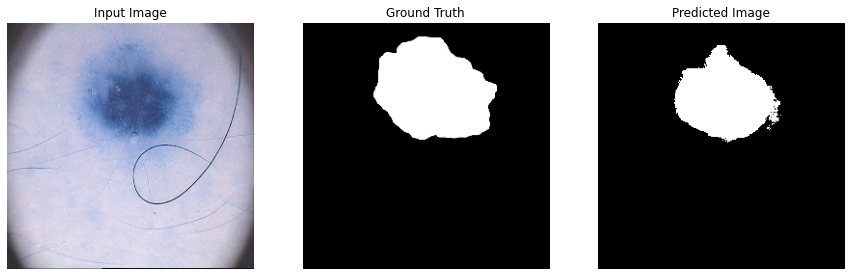

In [49]:
display_new(model_SA, 2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


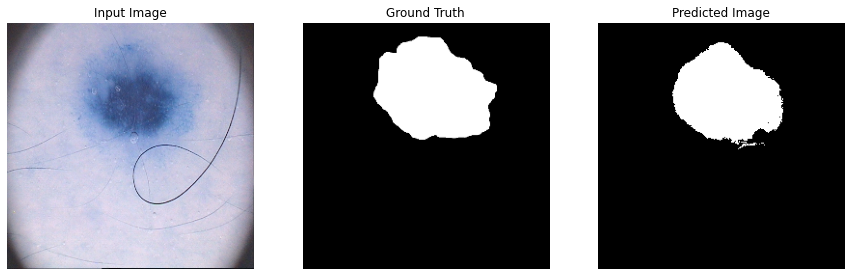

In [35]:
display_new(model_SPC, 2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


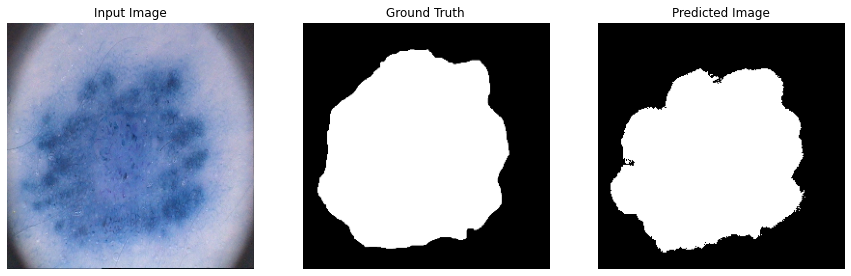

In [36]:
display_new(model_SA, 5)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


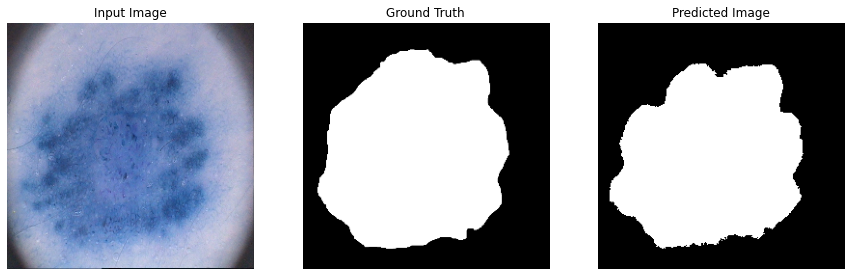

In [37]:
display_new(model_SPC, 5)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


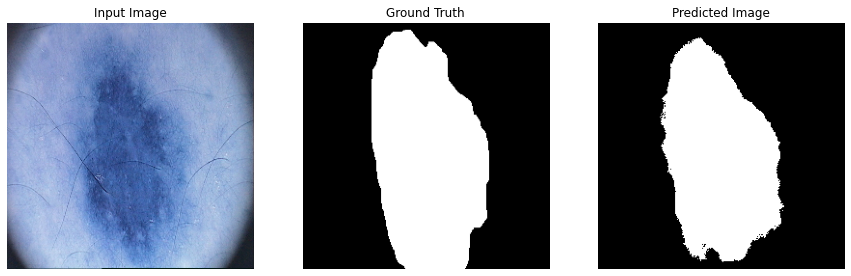

In [38]:
display_new(model_SA, 17)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


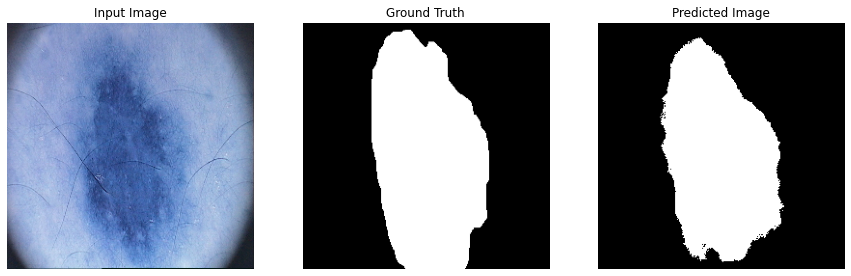

In [39]:
display_new(model_SA, 17)

In [ ]:
display_new(19)

In [ ]:
display_new(7)

In [ ]:
display_new(0)